In [1]:
from scipy.stats import crystalball,truncexpon,truncnorm,uniform
import numba as nb
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute,minimize

In [2]:
x_lim=[0,5]
y_lim=[0,10]
mu= 3
sig= 0.3
beta= 1
m= 1.4
f=0.6
lam=0.3
mub=0
sigb= 2.5

In [3]:
def sgx_pdf(x,beta,m,mu,sig):
    f= crystalball(beta=beta,m=m,loc=mu,scale=sig)
    pdf= f.pdf(x)/(f.cdf(x_lim[1])-f.cdf(x_lim[0]))
    return np.where((x_lim[0]<=x)&(x<=x_lim[1]),pdf,0)

sgx_pdf_= lambda x: sgx_pdf(x,beta,m,mu,sig)

def sgy_pdf(y,lam):
    scale= 1/lam
    b= (y_lim[1]-y_lim[0])/scale
    return truncexpon(b=b,loc=y_lim[0],scale=scale).pdf(y)

sgy_pdf_= lambda y: sgy_pdf(y,lam)

def bgx_pdf(x):
    return uniform(x_lim[0],x_lim[1]).pdf(x)

bgx_pdf_= lambda x: bgx_pdf(x)

def bgy_pdf(y,mub,sigb):
    a= (y_lim[0]-mub)/sigb 
    b= (y_lim[1]-mub)/sigb
    return truncnorm(a=a,b=b,loc=mub,scale=sigb).pdf(y)

bgy_pdf_= lambda y: bgy_pdf(y,mub,sigb)

def sg_pdf(x,y,beta,m,mu,sig,lam):
    return sgx_pdf(x,beta,m,mu,sig)*sgy_pdf(y,lam)

sg_pdf_= lambda x,y: sg_pdf(x,y,beta,m,mu,sig,lam)

def bg_pdf(x,y,mub,sigb):
    return bgx_pdf(x)*bgy_pdf(y,mub,sigb)

bg_pdf_= lambda x,y: bg_pdf(x,y,mub,sigb)

def tot_pdf(x,y,f,beta,m,mu,sig,lam,mub,sigb):
    return f*sg_pdf(x,y,beta,m,mu,sig,lam) + (1-f)*bg_pdf(x,y,mub,sigb)

tot_pdf_= lambda x,y: tot_pdf(x,y,f,beta,m,mu,sig,lam,mub,sigb)

def totx_pdf(x,f,beta,m,mu,sig): 
    return f*sgx_pdf(x,beta,m,mu,sig) + (1-f)*bgx_pdf(x)

totx_pdf_= lambda x: totx_pdf(x,f,beta,m,mu,sig)

def toty_pdf(x,f,lam,mub,sigb): 
    return f*sgy_pdf(x,f,lam,mub,sigb) + (1-f)*bgy_pdf(x)

toty_pdf_= lambda y: toty_pdf(y,f,lam,mub,sigb)




In [4]:
def get_samples(size=1):
    side= np.random.choice([0,1],size,p=[f,1-f])
    us= np.random.uniform(0,1,size)
    v= crystalball(beta,m,mu,sig)
    sg= v.ppf(us*(v.cdf(x_lim[1])-v.cdf(x_lim[0]))+v.cdf(x_lim[0]))
    bg= uniform.ppf(us,x_lim[0],x_lim[1])
    xs= np.where(side==0,sg,bg)

    return xs

def f_max(func,xrange,*args):
        minus_f= lambda x: -func(x,*args)
        x0= brute(minus_f,[xrange])[0]
        x0= minimize(minus_f,x0).x[0]
        return func(x0)

def accept_reject_2d(func,xrange,yrange,fmax,size,*args):
        x_samples= np.empty((1,))
        y_samples= np.empty((1,))
        #samples=[]
        #i=0

        while len(x_samples)<size:
                x= np.random.uniform(*xrange,size)
                y= np.random.uniform(*yrange,size)
                f_val= func(x,y,*args)
                #accept= np.random.choice([1,0],p=(f_val/fmax,1-f_val/fmax))
                f_rand= np.random.uniform(0,fmax,size)
                x_samples= np.hstack((x_samples,x[f_rand<f_val]))
                y_samples= np.hstack((y_samples,y[f_rand<f_val]))
                #if f_rand < f_val :
                
                #if accept:
                        #samples.append(f_val)
                
                #i+=1
        
        #print(f"Found {len(samples)} samples in {i} iterations")

        
        return x_samples[:size],y_samples[:size]



In [5]:
fmax= minimize(lambda x: -tot_pdf_(x[0],x[1]),[3,1]).x

In [6]:
fmax= tot_pdf_(fmax[0],fmax[1])
fmax

np.float64(0.16618815868950543)

In [56]:
x_samples,y_samples= accept_reject_2d(tot_pdf_,x_lim,y_lim,fmax,100000)

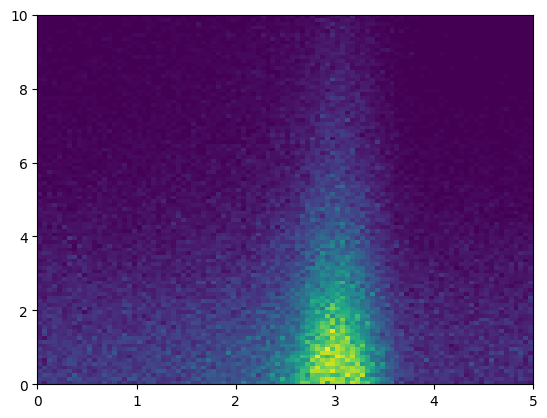

In [57]:
xs= np.linspace(0,5,400)
ys= np.linspace(0,10,400)
x_mesh,y_mesh= np.meshgrid(xs,ys)

f= tot_pdf_(x_mesh,y_mesh)


plt.hist2d(x_samples,y_samples,bins=100,range=[x_lim,y_lim],density=True)


plt.show()

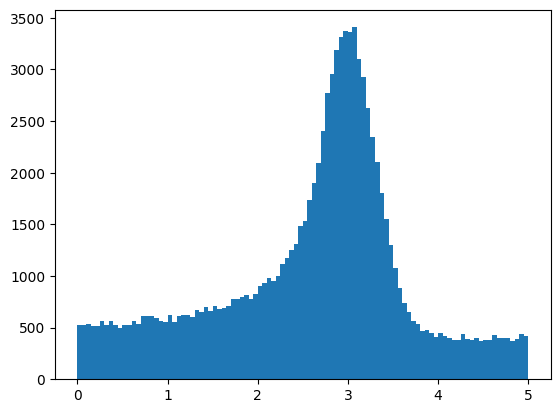

In [28]:
plt.hist(x_samples,bins=100)
plt.show()

In [42]:
x_samples,y_samples= get_samples(100000)
plt.hist2d(x_samples,y_samples,bins=100)
plt.show()

ValueError: 'p' must be 1-dimensional

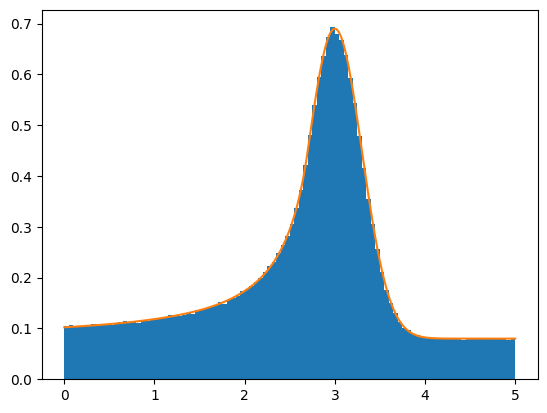

In [183]:
xs= np.linspace(0,5,500)


plt.hist(get_samples(1000000),bins=100,density=True)
plt.plot(xs,totx_pdf_(xs))
plt.show()


In [195]:
#%timeit -r 10 -n 1 np.random.normal(size=1000000)
#%timeit -r 10 -n 1 crystalball(beta,m,mu,sig).rvs(1000000)
%timeit -r 100 -n 1 get_samples(1000000)
#%timeit -r 10 -n 1 accept_reject(totx_pdf_,x_lim,fmax,1000000)

392 ms ± 47.4 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [79]:
def odd_fn():
    die= np.random.choice([0,1],p=[0.8,0.2])
    assert die==0, "died"

interactive(children=(FloatSlider(value=1.0, description='beta', max=5.0), FloatSlider(value=1.4, description=…

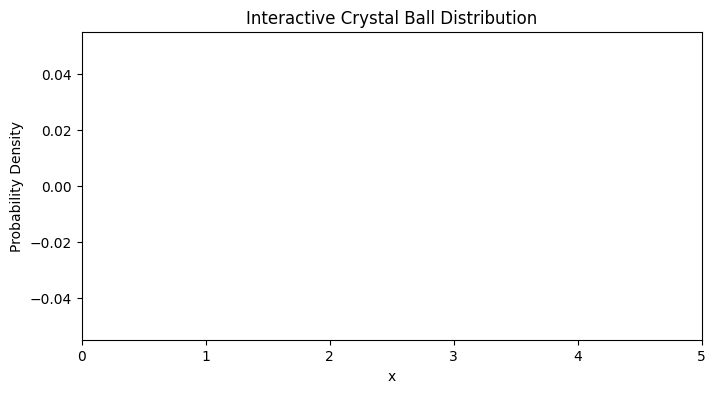

In [83]:

from ipywidgets import interact, FloatSlider

# ... existing code ...

def interactive_crystalball_plot(beta=1, m=1.4, mu=3, sig=0.3):
    x = np.linspace(0, 5, 400)
    f = crystalball(beta=beta, m=m, loc=mu, scale=sig)
    pdf = f.pdf(x) / (f.cdf(x_lim[1]) - f.cdf(x_lim[0]))  # Normalize the PDF

    plt.figure(figsize=(8, 4))
    plt.plot(x, pdf, label='Crystal Ball PDF')
    plt.title('Interactive Crystal Ball Distribution')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.xlim(x_lim)
    plt.ylim(0, np.max(pdf) * 1.1)
    plt.legend()
    plt.grid()
    plt.show()

interact(interactive_crystalball_plot,
         beta=FloatSlider(value=1, min=0, max=5, step=0.1),
         m=FloatSlider(value=1.4, min=0, max=5, step=0.1),
         mu=FloatSlider(value=3, min=0, max=5, step=0.1),
         sig=FloatSlider(value=0.3, min=0, max=5, step=0.1));
